# Adding covariates to model parameters

In this tutorial, we will develop simple models with covariates.
We have two types of covariates: continuous and categorical. The continuous covariates can be multi-dimensional (explained in another tutorial). 

We start with continuous covariates called $X$. A random parameter 
$\theta$ has prior 

$$
\theta_r \sim \mathrm{LogNorm}(\mu_\theta + \alpha_X X_r, \sigma_\theta).
$$

Here, $\alpha_X$ is the weight of the covariate $X$.

In HBOMS, we first define the covariate $X$ and then add $X$ to to parameter $\theta$

```python
import hboms

covs = [
    hboms.Covariate("X"),
    # other covariates...
]
params = [
    hboms.Parameter("theta", 1.0, "random", covariates=["X"]),
    # other parameters...
]
```
Note that by default, covariates are continuous.
We then add the list `covs` to the definition of the HBOMS model

```python
hbm = hboms.HbomsModel(
    params = params,
    covariates = covs,
    # other components...
]
```

## Predator-prey model with a covariate

Let's look at a simple concrete example in which we add a continuous covariate called $A$ to the prey growth rate ($a$) in the predator-pray model.
To keep it simple, we assume that all other parameters are known (and constant),
and also that we just observe the prey population ($X$).

In [1]:
# import the hboms package
import hboms

# define model parameters
params = [
    hboms.Parameter("a", 1.0, "random", covariates=["A"]),
    hboms.Parameter("b", 1.0, "const"),
    hboms.Parameter("c", 0.5, "const"),
    hboms.Parameter("d", 1.0, "const"),
    hboms.Parameter("x0", 1.0, "const"),
    hboms.Parameter("y0", 1.0, "const"),
    hboms.Parameter("sigma", 0.2, "const"),
]

# define covariates
covs = [
    hboms.Covariate("A"),
]

# define the state
state = [
    hboms.Variable("x"),
    hboms.Variable("y"),
]

# define the IVP (ODEs and initial conditions)
odes = """
ddt_x = a*x - b*x*y;
ddt_y = b*c*x*y - d*y;
"""

init = """
x_0 = x0;
y_0 = y0;
"""

# define observations and their distributions.
obs = [
    hboms.Observation("X"),
]

dists = [
    hboms.StanDist("lognormal", obs_name="X", params=["log(x)", "sigma"]),
]

# now define the HBOMS model
hbm = hboms.HbomsModel(
    "lv_cov_example",
    params = params,
    state = state,
    odes = odes,
    init = init,
    covariates = covs,
    obs = obs,
    dists = dists,
)

We will now simulate some data in Python. Fit this, we sample log-normally distributed parameters $a$, with location parameter dependent on a covariate.

In [2]:
import numpy as np
import scipy.stats as sts
from scipy.integrate import solve_ivp

def lv_model_sys(t, u, a, b, c, d):
    x, y = u
    ddt_x = a*x - b*x*y
    ddt_y = b*c*x*y - d*y
    return np.array([ddt_x, ddt_y])

x0, y0 = 1.0, 1.0
b, c, d = 1.0, 0.5, 1.0
sigma = 0.2
u0 = np.array([x0, y0])
R = 24
ts = np.linspace(1, 10, 20)
A = sts.norm.rvs(0, 1, size=R)
loc_a = 0.0
scale_a = 0.1
weight_A_a = 0.1
a_indiv = np.exp(sts.norm.rvs(loc=loc_a + weight_A_a * A, scale=scale_a))

def simulate_lv_model(a):
    sol = solve_ivp(
        lv_model_sys, y0=u0, t_span=(np.min(ts), np.max(ts)), 
        t_eval=ts, args=(a, b, c, d)
    )
    
    x = sol.y[0]
    X = np.exp(sts.norm.rvs(loc=np.log(x), scale=sigma))
    return X

Xs = [simulate_lv_model(a) for a in a_indiv]

Plot the data to make sure we did not make any mistakes.

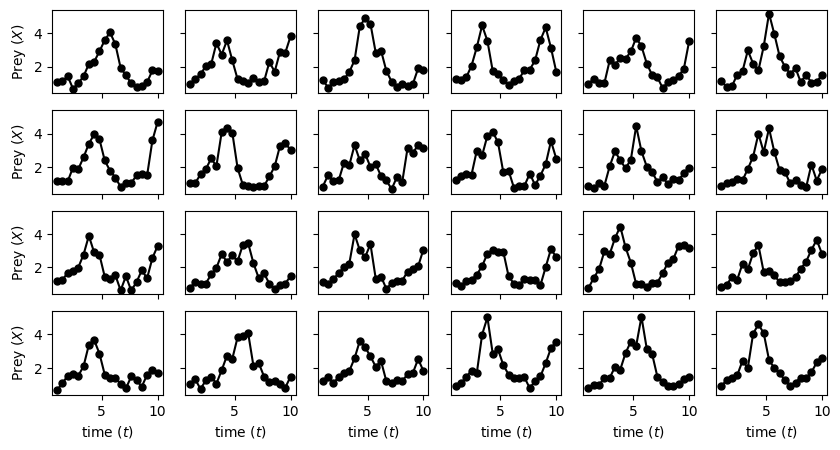

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 6, figsize=(10,5), sharex=True, sharey=True)

for ax, X in zip(axs.flat, Xs):
    ax.plot(ts, X, marker='o', color='k', markersize=5)

for ax in axs[-1,:]:
    ax.set_xlabel("time ($t$)")
for ax in axs[:,0]:
    ax.set_ylabel("Prey ($X$)")

Now collect data into a dictionary and check the initial parameter guess. This data dictionary has to include the covariate with one value per unit.

10:56:31 - cmdstanpy - INFO - CmdStan start processing
10:56:31 - cmdstanpy - INFO - Chain [1] start processing
10:56:32 - cmdstanpy - INFO - Chain [1] done processing


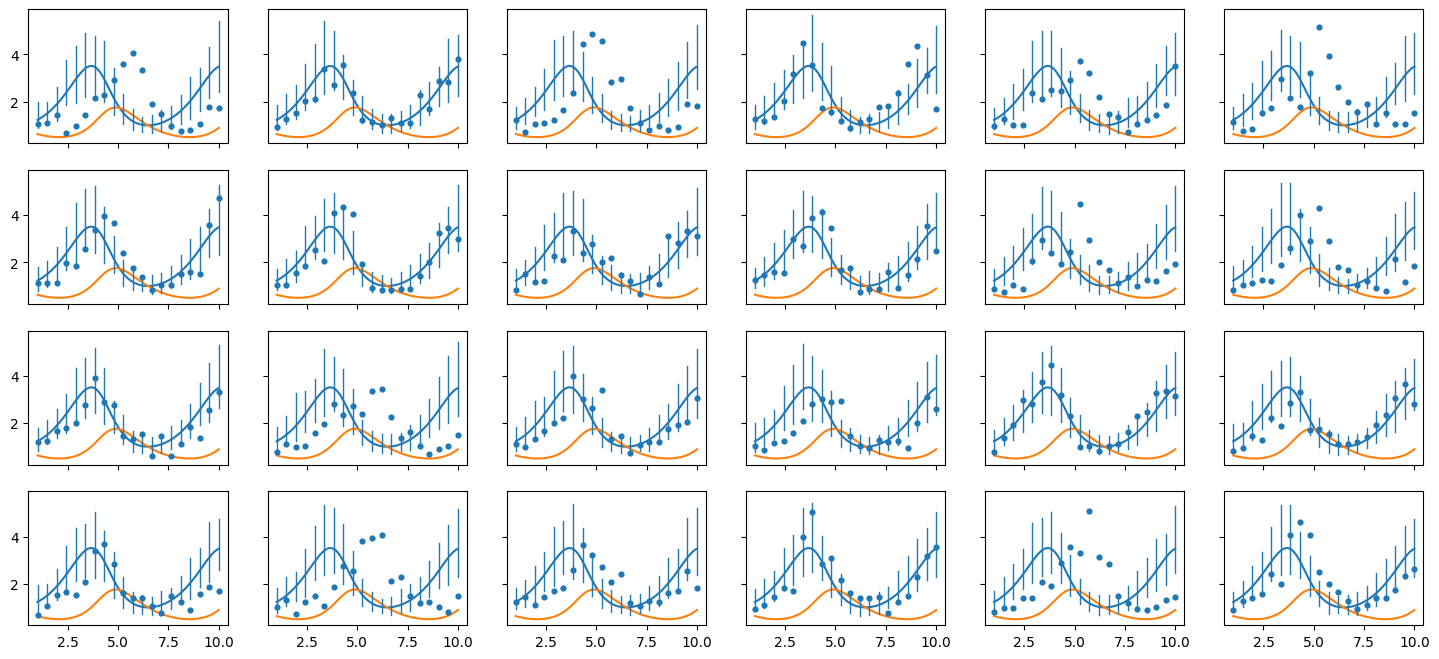

In [4]:
data_dict = {
    "Time" : [ts for _ in range(R)],
    "X" : Xs,
    "A" : A
}

fig = hbm.init_check(data_dict)

Since the initial guess looks OK, we can fit the model, and inspect the model fit

10:56:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

10:57:12 - cmdstanpy - INFO - CmdStan done processing.


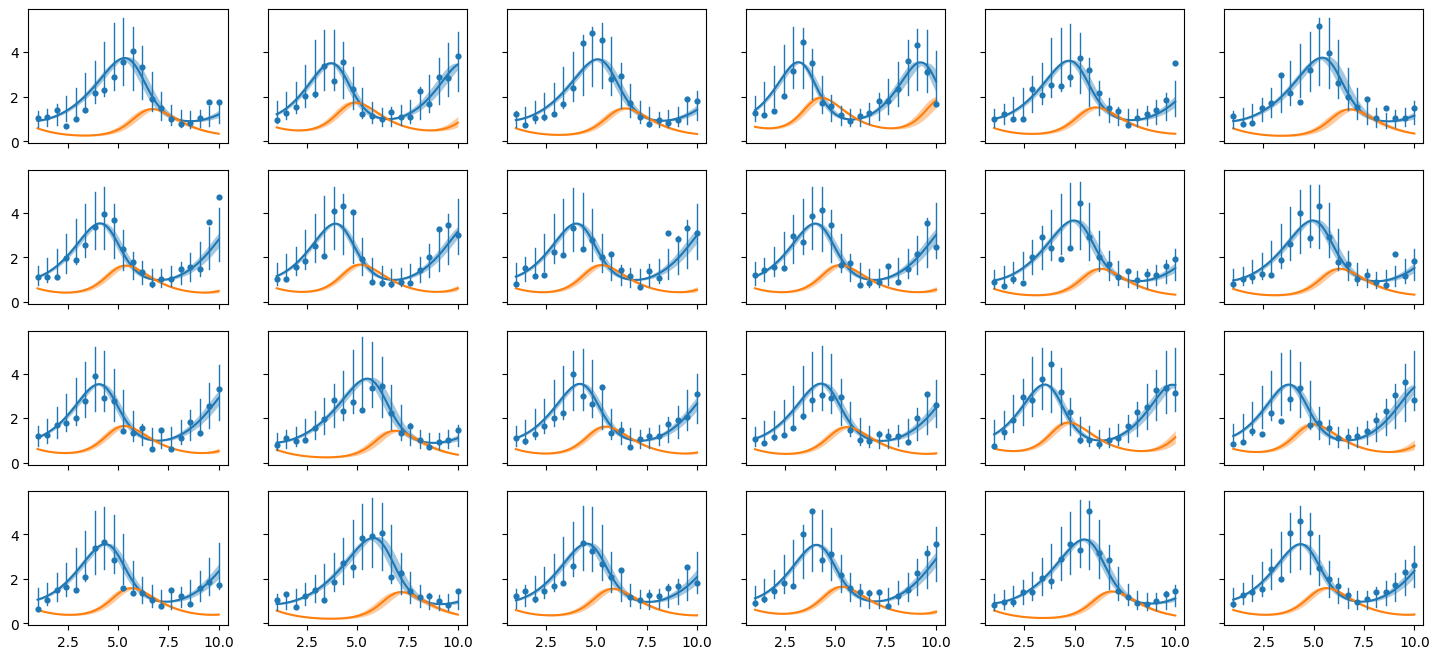

In [5]:
hbm.sample(
    data_dict, threads_per_chain=R, chains=2, refresh=1, 
    step_size=0.01, iter_warmup=500, iter_sampling=500
)

fig = hbm.post_pred_check(data_dict)

Now we can compare the estimated weight of the covariate with the ground-truth value.
In the Stan model generated by HBOMS, the weight parameter is called `weight_A_a`.

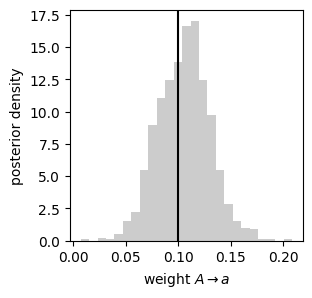

In [6]:
weight_sams = hbm.fit.weight_A_a

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.hist(weight_sams, 25, color='0.8', label="posterior", density=True)
ax.axvline(weight_A_a, color='k', label="ground truth")

ax.set_ylabel("posterior density")
ax.set_xlabel("weight $A \\rightarrow a$");

## A model with a categorical covariate (TODO)